## Import modules

In [1]:
from pathlib import Path

import requests
import zipfile
import io

import pandas as pd
import numpy as np

import joblib

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import BallTree
from sklearn.metrics import silhouette_score

from kneed import KneeLocator

from utils import (unpack_datetime, UnpackWhat)

# Earth's radius / kilometers in one radian
EARTH_RADIUS_KM = 6371.0

pio.renderers.default = "jupyterlab+png"

## Recupération des data

In [2]:
# URL of the ZIP file
JEDHA_DATASET_URL = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+non+Supervis%C3%A9/Projects/uber-trip-data.zip"

# base DATA folder
DATA_BASE_DIR = Path.joinpath(Path.cwd(), 'data')
DATA_BASE_DIR.mkdir(exist_ok=True)

# raw data folder
RAW_DATA_DIR = DATA_BASE_DIR / "raw"
RAW_DATA_DIR.mkdir(exist_ok=True)

# if nothing in raw folder, download and unzip JEDHA dataset archive
if not any(RAW_DATA_DIR.iterdir()):
    print("RAW data folder is empty. Downloading and extracting data...")

    response = requests.get(JEDHA_DATASET_URL)
    response.raise_for_status()  # Ensure the request was successful

    # print("Unzipping the contents...")
    # with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    #     zip_ref.extractall(DATA_BASE_DIR)


    # Just extract the content of 'uber-trip-data/' folder
    print("Extracting 'uber-trip-data/' contents...")
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        for member in zip_ref.namelist():
            if member.startswith("uber-trip-data/") and not member.endswith("/"):
                # Extract into our destination directory (removing the top folder name)
                relative_path = Path(member).relative_to("uber-trip-data")
                target_path = RAW_DATA_DIR / relative_path
                target_path.parent.mkdir(parents=True, exist_ok=True)
                with zip_ref.open(member) as source, open(target_path, "wb") as target:
                    target.write(source.read())

    print(f"Extraction completed. Files are in: {RAW_DATA_DIR.resolve()}")
else:
    print(f"RAW data folder is not empty. Skipping download. Contents already exist in: {RAW_DATA_DIR.resolve()}")
    
# Lister les fichiers extraits
print("\nListe des fichiers disponibles :")
for path in RAW_DATA_DIR.rglob("*"):
    if path.is_file():
        print(f"- {path.relative_to(RAW_DATA_DIR)}")

RAW data folder is not empty. Skipping download. Contents already exist in: /workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw

Liste des fichiers disponibles :
- taxi-zone-lookup.csv
- uber-raw-data-apr14.csv
- uber-raw-data-aug14.csv
- uber-raw-data-janjune-15.csv.zip
- uber-raw-data-jul14.csv
- uber-raw-data-jun14.csv
- uber-raw-data-may14.csv
- uber-raw-data-sep14.csv


## Chargement des données

In [3]:
raw_data_files_2014 = [file for file in RAW_DATA_DIR.glob('uber-raw-data*.csv')]
raw_data_files_2014.sort()

print("Nb of files: ", len(raw_data_files_2014))
print(raw_data_files_2014)

Nb of files:  6
[PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-apr14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-aug14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jul14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-jun14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-may14.csv'), PosixPath('/workspaces/jedha-cdsd-cert-projects/bloc-3/Uber Pickups/data/raw/uber-raw-data-sep14.csv')]


In [4]:
# Load N file (1 to 6)
NB_FILES_TO_LOAD = 6

raw_data_df = pd.concat(map(pd.read_csv, raw_data_files_2014[0:NB_FILES_TO_LOAD]))

# normalize column names
raw_data_df.columns = ['date_time', 'lat', 'lon', 'base']

# Convert datetime
raw_data_df['date_time'] = pd.to_datetime(raw_data_df['date_time'])

# Unpack datetime
unpack_datetime(raw_data_df, 'date_time', UnpackWhat.ALL, prefix='dt', inplace=True)

# Pour réduire/recentrer les datas on va appliquer un filtrage des outliers aux colonnes latitude et longitude
print("Initial shape: ", raw_data_df.shape)

for col in ["lat", "lon"] :
    col_mean = raw_data_df[col].mean()
    col_std = raw_data_df[col].std()
    range_min = col_mean - 3 * col_std
    range_max = col_mean + 3 * col_std
  
    raw_data_df = raw_data_df[(raw_data_df[col] > range_min) & (raw_data_df[col] <= range_max)]
    
print("New Shape: ", raw_data_df.shape)

Initial shape:  (4534327, 14)
New Shape:  (4301626, 14)


## Clustering

### Exploration sur un jeu de données restreint

#### Préparation du dataset de test

In [5]:
# Let analyze 18h on first thursday of September
month = 9 # September
weekday = 3 # Thursday
hour = 18
day = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_weekday"] == weekday)]["dt_day"].unique()[0]

assess_hour_df = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_weekday"] == weekday) & (raw_data_df["dt_hour"] == hour)]["dt_day"].unique()[0]

# Keep hourly rides
assess_hour_df  = raw_data_df[(raw_data_df["dt_month"] == month) & (raw_data_df["dt_day"] == day) & (raw_data_df["dt_hour"] == hour)]

assess_hour_df.shape

(2949, 14)

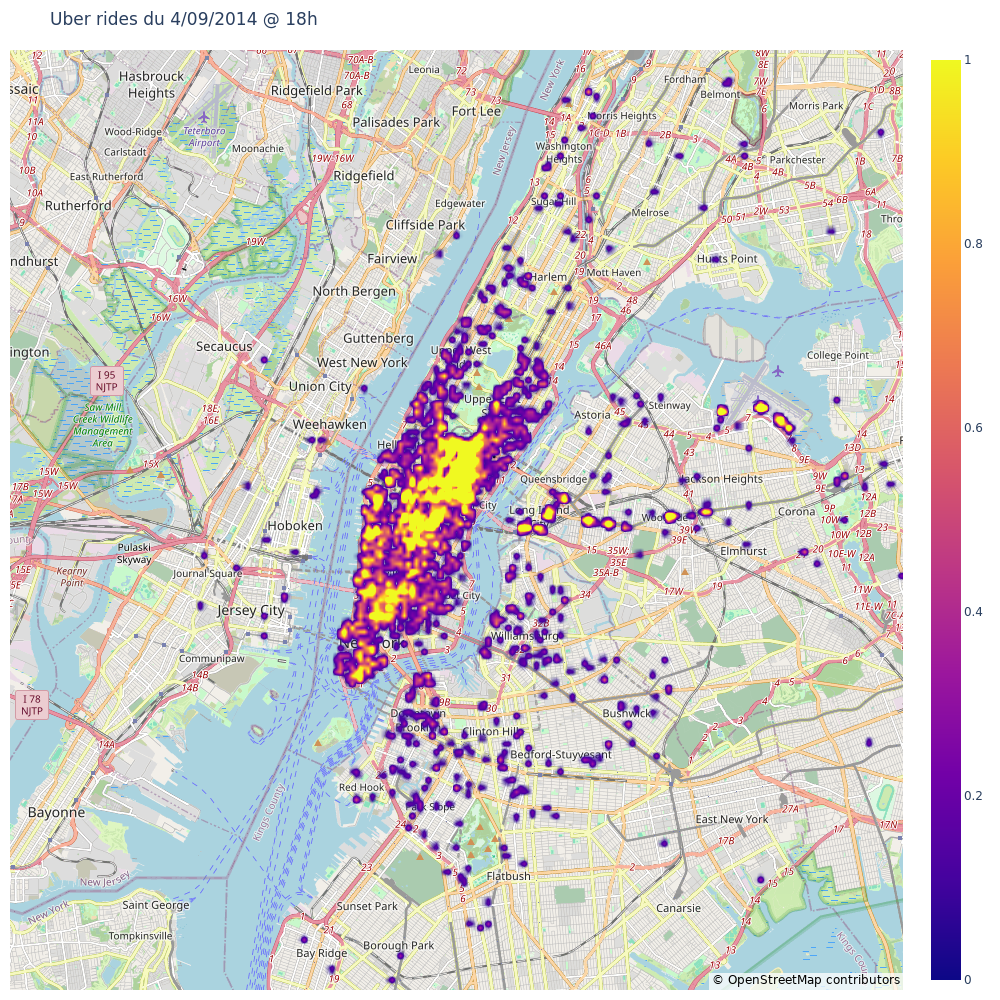

In [6]:
# Base map settings
mapbox_style = "open-street-map" #"carto-positron"
mapbox_center = {"lat": assess_hour_df["lat"].mean(), "lon": assess_hour_df["lon"].mean()}
    
fig_hour = px.density_map(
    assess_hour_df,
    lat="lat",
    lon="lon",
    z=None,
    radius=5,
    center=mapbox_center,
    zoom=11,
    map_style=mapbox_style,
    title= f"Uber rides du {day}/{month:02d}/{assess_hour_df['dt_year'].unique()[0]} @ {hour}h"
)

fig_hour.update_layout(
    margin=dict(l=10, r=10, t=50, b=10),
)

fig_hour.update_layout(height=1000, width=1000)

fig_hour.show()


#### DBSCAN

In [7]:
# Prepare dataset
# 1. select features
dbscan_df = assess_hour_df[["lat", "lon"]]
print(dbscan_df.shape)

# We will use the haversine metric and ball tree algorithm to calculate great circle distances between points.
# Coordinates get converted to radians, because scikit-learn’s haversine metric needs radian units:
dbscan_radians_df = np.radians(dbscan_df)


(2949, 2)


Estimate EPS:
- https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
- https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/ (kNNdistplot)
- https://medium.com/@revag2014/dbscan-an-easy-clustering-algorithm-and-also-how-to-optimize-it-using-grid-search-69a382b63e85

vs. Infer EPS:
- eps is the distance threshold that determines the maximum distance between two points for them to be considered part of the same cluster.
- let use radius of earth and radius of cluster: epsilon = radius / earth_radius



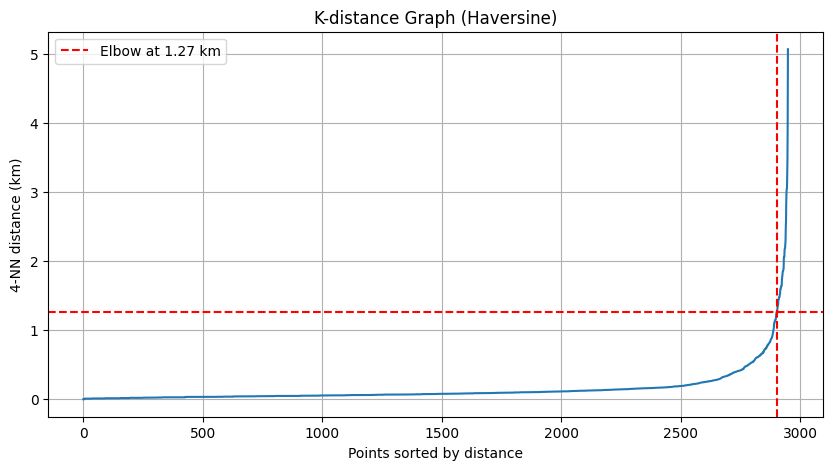

Suggested eps for DBSCAN (radians): 0.000199
Suggested eps for DBSCAN (km): 1.27


In [8]:

# Build BallTree with haversine distance
k = 4  # usually min_samples - 1
tree = BallTree(dbscan_radians_df, metric='haversine')

# Get distances to the k nearest neighbors
distances, indices = tree.query(dbscan_radians_df, k=k)
k_distances_rad = distances[:, k - 1]
k_distances_km = np.sort(k_distances_rad) * EARTH_RADIUS_KM  # convert to km

# Plot the k-distance graph
plt.figure(figsize=(10, 5))
plt.plot(k_distances_km)
plt.ylabel(f"{k}-NN distance (km)")
plt.xlabel("Points sorted by distance")
plt.title("K-distance Graph (Haversine)")
plt.grid(True)

# Optional: detect the elbow
kneedle = KneeLocator(range(len(k_distances_km)), k_distances_km, curve='convex', direction='increasing')
plt.axvline(kneedle.knee, color='red', linestyle='--', label=f"Elbow at {kneedle.knee_y:.2f} km")
plt.axhline(kneedle.knee_y, color='red', linestyle='--')
plt.legend()

plt.show()

# Suggested eps for DBSCAN (in radians!)
eps_radians = kneedle.knee_y / EARTH_RADIUS_KM
print(f"Suggested eps for DBSCAN (radians): {eps_radians:.6f}")
print(f"Suggested eps for DBSCAN (km): {kneedle.knee_y:.2f}")

Epsilon:  0.0001993407628315806
Found 5 clusters: [-1  0  1  2  3]
Clusterized rides: 98.47%


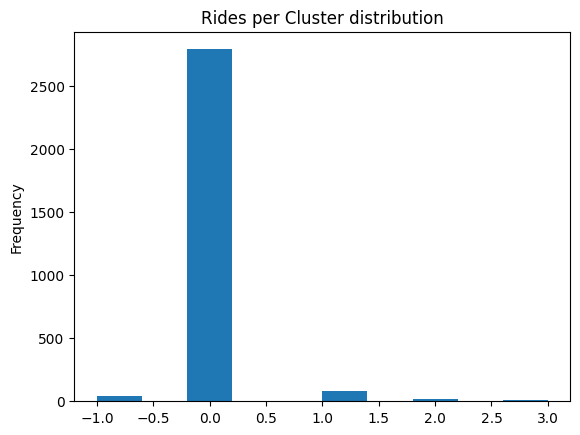

In [9]:
# radius km
EPS_KM = 1.27

# eps: distance threshold that determines the maximum distance between two points for them to be considered part of the same cluster.
epsilon = EPS_KM / EARTH_RADIUS_KM

# epsilon = 0.00036159
# 0.00015696101377226163
print("Epsilon: ", epsilon)

min_samples = 5

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric="haversine", algorithm="ball_tree")
dbscan.fit(dbscan_radians_df)
    
dbscan_cluster_df = dbscan_df.copy()
dbscan_cluster_df["dbscan_cluster"] = dbscan.labels_

clusters = np.unique(dbscan.labels_)
print(f"Found {len(clusters)} clusters: {clusters}")
ratio_clusterized = (dbscan_cluster_df["dbscan_cluster"] != -1).sum() * 100 / len(dbscan_cluster_df)
print(f"Clusterized rides: {ratio_clusterized:.2f}%")

fig = dbscan_cluster_df["dbscan_cluster"].plot.hist(title="Rides per Cluster distribution")
# fig.plot()


In [10]:
def dbscan_radians_gridsearch(eps, min_samples_candidates, x_radians):
    scores = []
    all_label = []

    for i, min_samples in enumerate(min_samples_candidates):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="haversine", algorithm="ball_tree")
        dbscan.fit(x_radians)
        labels = dbscan.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 2) or (num_clusters > 25):
            scores.append(-200)
            all_label.append("Poor")
            print("@ iteration :", i, "ep =", eps, "min_sample =", min_samples,
                  "number of cluster =", num_clusters, "moving on ...")
            continue
        scores.append(silhouette_score(x_radians, labels))
        all_label.append(labels)

        print("@ iteration :", i, "score :", scores[-1], "Number of clusters :", num_clusters)

    best_index = np.argmax(scores)
    best_parameters = (eps, min_samples_candidates[best_index])
    best_labels = all_label[best_index]
    best_score = scores[best_index]

    return {'best_eps': best_parameters[0],
            'best_min_samples': best_parameters[1],
            'best_labels': best_labels,
            'best_score': best_score}

def estimate_dbscan_parameters(eps_candidates, min_samples_candidates, x_radians, n_jobs=-1):
    
    eps_estimates = joblib.Parallel(n_jobs=-1, return_as="generator")(
        joblib.delayed(dbscan_radians_gridsearch)(eps, min_samples_candidates, x_radians) for eps in eps_candidates
    )

    # consume and combine
    estimates = [e for e in eps_estimates]

    df = pd.DataFrame(estimates)

    best_row_df = df[df["best_score"] == df["best_score"].max()]
    
    # return max best_score
    return best_row_df.iloc[0].to_dict()    


In [11]:
# de 100 m à 2 km
epsilon_candidates = np.linspace(0.1 / EARTH_RADIUS_KM, 2 / EARTH_RADIUS_KM, num=50)
min_samples_candidates = np.arange(2, 25, step=2)

print(min_samples_candidates)

best_dbscan_params = estimate_dbscan_parameters(epsilon_candidates, min_samples_candidates, dbscan_radians_df)

print(best_dbscan_params)

[ 2  4  6  8 10 12 14 16 18 20 22 24]


@ iteration : 0 ep = 5.8299885642532e-05 min_sample = 2 number of cluster = 59 moving on ...
@ iteration : 0 ep = 8.2644892833919e-05 min_sample = 2 number of cluster = 38 moving on ...
@ iteration : 0 ep = 1.5696123057604773e-05 min_sample = 2 number of cluster = 254 moving on ...
@ iteration : 0 ep = 4.004113024899176e-05 min_sample = 2 number of cluster = 78 moving on ...
@ iteration : 0 ep = 2.7868626653298268e-05 min_sample = 2 number of cluster = 116 moving on ...
@ iteration : 0 ep = 2.178237485545152e-05 min_sample = 2 number of cluster = 162 moving on ...
@ iteration : 0 ep = 0.00011307615182315274 min_sample = 2 number of cluster = 26 moving on ...
@ iteration : 0 ep = 7.04723892382255e-05 min_sample = 2 number of cluster = 48 moving on ...
@ iteration : 0 @ iteration : 0 ep = 4.6127382046838515e-05 min_sample = 2 number of cluster = 71 moving on ...
ep = 3.395487845114502e-05 min_sample = 2 number of cluster = 86 moving on ...
@ iteration : 0 ep = 0.000106989900025306 min_sa

In [12]:
best_dbscan_params

{'best_eps': 0.00027740495036501496,
 'best_min_samples': 6,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0]),
 'best_score': 0.6342919944540828}

Found 5 clusters: [-1  0  1  2  3]
Clusterized rides: 98.44%


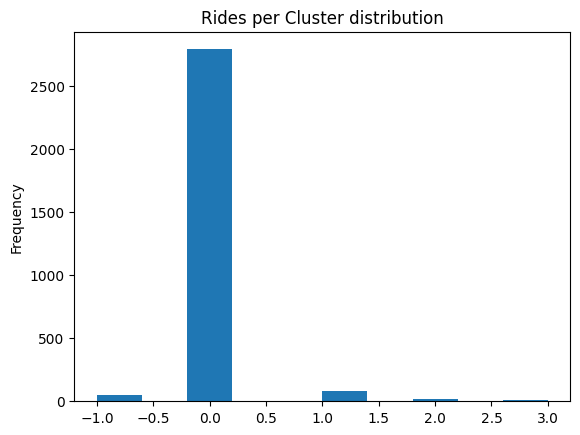

In [13]:
eps = best_dbscan_params["best_eps"]
min_samples = best_dbscan_params["best_min_samples"]

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric="haversine", algorithm="ball_tree")
dbscan.fit(dbscan_radians_df)
    
dbscan_cluster_df = dbscan_df.copy()
dbscan_cluster_df["dbscan_cluster"] = dbscan.labels_

clusters = np.unique(dbscan.labels_)
print(f"Found {len(clusters)} clusters: {clusters}")
ratio_clusterized = (dbscan_cluster_df["dbscan_cluster"] != -1).sum() * 100 / len(dbscan_cluster_df)
print(f"Clusterized rides: {ratio_clusterized:.2f}%")

fig = dbscan_cluster_df["dbscan_cluster"].plot.hist(title="Rides per Cluster distribution")

In [14]:
dbscan_cluster_df["dbscan_cluster"].value_counts()


dbscan_cluster
 0    2791
 1      85
-1      46
 2      19
 3       8
Name: count, dtype: int64

In [15]:
dbscan_centroids_df = dbscan_cluster_df[dbscan_cluster_df["dbscan_cluster"] != -1].groupby("dbscan_cluster")[["lat", "lon"]].mean().reset_index()
dbscan_centroids_df

dbscan_cluster        lat        lon
0               0  40.743231 -73.981157
1               1  40.772116 -73.872647
2               2  40.836221 -73.937084
3               3  40.754188 -73.839750

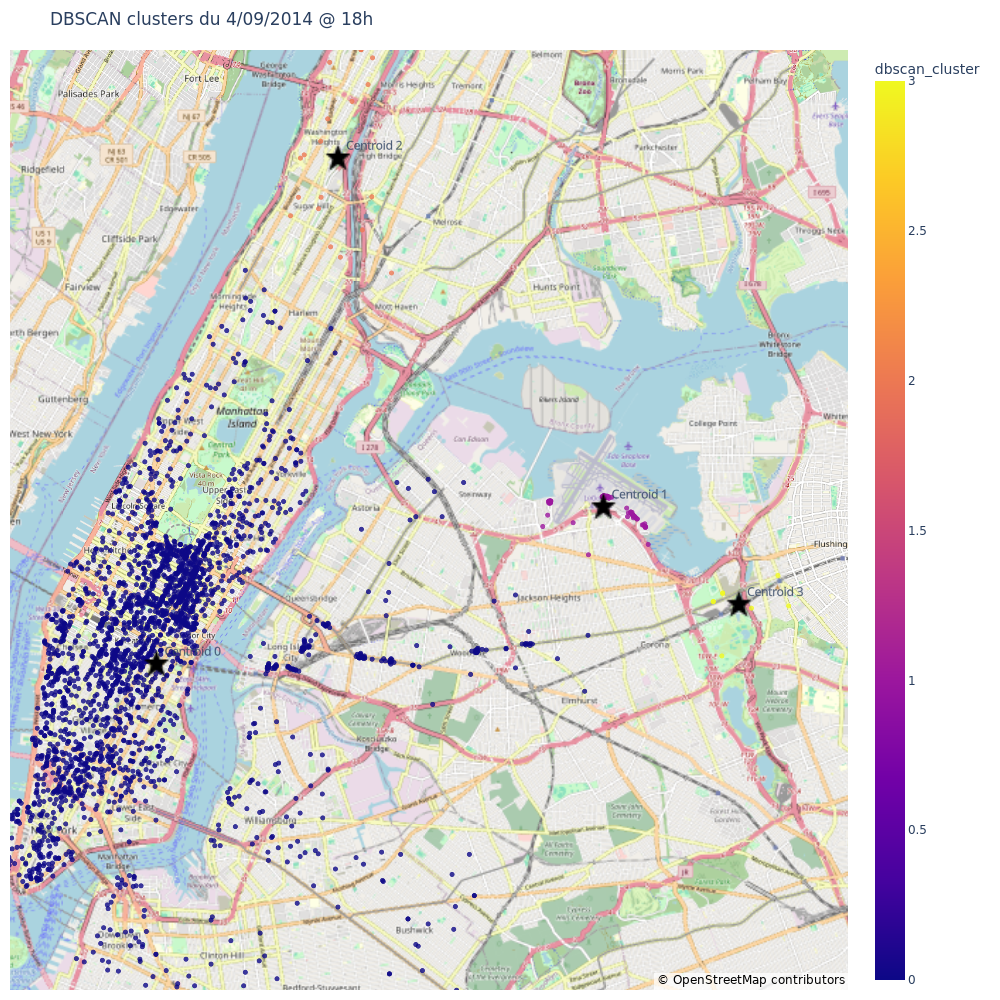

In [24]:
plot_dbscan_cluster_df = dbscan_cluster_df[dbscan_cluster_df["dbscan_cluster"] != -1]

# Base map settings
mapbox_style = "open-street-map" #"carto-positron"
# mapbox_center = {"lat": plot_dbscan_cluster_df["lat"].mean(), "lon": plot_dbscan_cluster_df["lon"].mean()}
mapbox_center = {"lat": 40.7697, "lon": -73.9150}
    
# Les rides colorées par cluster    
fig_hour = px.scatter_map(
    plot_dbscan_cluster_df,
    lat="lat",
    lon="lon",
    opacity = 0.8,
    color="dbscan_cluster",
    # radius=5,
    center=mapbox_center,
    zoom=11.5,
    map_style=mapbox_style,
    title= f"DBSCAN clusters du {day}/{month:02d}/{assess_hour_df['dt_year'].unique()[0]} @ {hour}h"
)

fig_hour.add_trace(go.Scattermap(
    lat=dbscan_centroids_df["lat"],
    lon=dbscan_centroids_df["lon"],
    mode="markers+text",
    marker=dict(
        size=18,
        color="black",
        symbol="star"
    ),
    # name="",
    showlegend=False,
    text=[f"Centroid {i}" for i in dbscan_centroids_df.index],
    textposition="top right",
    subplot="map"
))

fig_hour.update_layout(
    margin=dict(l=10, r=10, t=50, b=10),
)

fig_hour.update_layout(height=1000, width=1000)

fig_hour.show()

Moins de clusters, mais la repartition géographique semble correcte.

Ce qui est intéressant avec DBSCAN, c'est qu'il est capable d'ignorer un certain nombre de points (outliers) et de proposer une solution adaptable.